In [ ]:
!pip install jsonlines

In [ ]:
import torch
import h5py
import json
import jsonlines
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam

TEXT_JSON = '/content/drive/MyDrive/UNH Data Science Courses/DSCI 6004 - NLP/Final Project/data/sarcasm_data.json'
AUDIO_PICKLE = '/content/drive/MyDrive/UNH Data Science Courses/DSCI 6004 - NLP/Final Project/data/audio_features.p'
BERT_UTTERANCE_EMBEDDINGS = '/content/drive/MyDrive/UNH Data Science Courses/DSCI 6004 - NLP/Final Project/data/bert-output.jsonl'
BERT_CONTEXT_EMBEDDINGS = '/content/drive/MyDrive/UNH Data Science Courses/DSCI 6004 - NLP/Final Project/data/bert-output-context.jsonl'
VISUAL_UTTERANCE = '/content/drive/MyDrive/UNH Data Science Courses/DSCI 6004 - NLP/Final Project/data/features/utterances_final/resnet_pool5.hdf5'
VISUAL_CONTEXT = '/content/drive/MyDrive/UNH Data Science Courses/DSCI 6004 - NLP/Final Project/data/features/context_final/resnet_pool5.hdf5'

In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load text data
with open(TEXT_JSON, 'r') as f:
    sarcasm_data = json.load(f)

# Load visual data
utterance_visual_data = h5py.File(VISUAL_UTTERANCE)
context_visual_data = h5py.File(VISUAL_CONTEXT)

# Extract visual features for context and utterances
context_features = {key: context_visual_data[key][...] for key in context_visual_data.keys()}
utterance_features = {key: utterance_visual_data[key][...] for key in utterance_visual_data.keys()}

# Load audio features
audio_features = pd.read_pickle(AUDIO_PICKLE)

# Load BERT embeddings for utterances
text_bert_embeddings = []
with jsonlines.open(BERT_UTTERANCE_EMBEDDINGS) as utterances:
  for utterance in utterances:
    features = utterance["features"][0]
    bert_embedding_target = np.mean([np.array(features["layers"][layer]["values"]) for layer in range(4)], axis=0)
    text_bert_embeddings.append(np.copy(bert_embedding_target))

# Load BERT embeddings for context
with jsonlines.open(BERT_CONTEXT_EMBEDDINGS) as utterances:
  context_utterance_embeddings = []
  for utterance in utterances:
    features = utterance["features"][0]
    bert_embedding_target = np.mean([np.array(features["layers"][layer]["values"]) for layer in [0, 1, 2, 3]], axis=0)
    context_utterance_embeddings.append(np.copy(bert_embedding_target))

In [ ]:
class SarcasmDataset(Dataset):
    def __init__(self, sarcasm_data, audio_features, utterance_visual_data, context_visual_data, text_bert_embeddings, context_utterance_embeddings):
        self.data = sarcasm_data
        self.audio_features = audio_features
        self.utterance_visual_data = utterance_visual_data
        self.context_visual_data = context_visual_data
        self.text_bert_embeddings = text_bert_embeddings
        self.context_utterance_embeddings = context_utterance_embeddings

        # Calculate feature lengths based on the dataset
        self.max_text_embedding_length = len(text_bert_embeddings[0])
        self.max_context_embedding_length = len(context_utterance_embeddings[0])
        self.max_audio_feature_length = max(audio_features[id_].size for id_ in audio_features.keys())
        self.max_visual_utterance_length = max(np.prod(utterance_visual_data[id_].shape) for id_ in utterance_visual_data.keys())
        self.max_visual_context_length = max(np.prod(context_visual_data[id_].shape) for id_ in context_visual_data.keys())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        id_ = list(self.data.keys())[idx]
        sample = self.data[id_]

        # Retrieve features
        text_embedding = torch.tensor(self.text_bert_embeddings[idx]).float()
        context_embedding = torch.tensor(self.context_utterance_embeddings[idx]).float()
        audio_feature = torch.tensor(np.array(self.audio_features.get(id_, np.zeros(self.max_audio_feature_length)))).flatten().float()
        visual_utterance_feature = torch.tensor(np.array(self.utterance_visual_data.get(id_, np.zeros(self.max_visual_utterance_length)))).flatten().float()
        visual_context_feature = torch.tensor(np.array(self.context_visual_data.get(id_, np.zeros(self.max_visual_context_length)))).flatten().float()

        # Pad features to ensure uniform length
        text_embedding = torch.nn.functional.pad(text_embedding, (0, self.max_text_embedding_length - text_embedding.size(0)))
        context_embedding = torch.nn.functional.pad(context_embedding, (0, self.max_context_embedding_length - context_embedding.size(0)))
        audio_feature = torch.nn.functional.pad(audio_feature, (0, self.max_audio_feature_length - audio_feature.size(0)))
        visual_utterance_feature = torch.nn.functional.pad(visual_utterance_feature, (0, self.max_visual_utterance_length - visual_utterance_feature.size(0)))
        visual_context_feature = torch.nn.functional.pad(visual_context_feature, (0, self.max_visual_context_length - visual_context_feature.size(0)))

        # Combine all features
        combined_features = torch.cat([
            text_embedding,
            context_embedding,
            audio_feature,
            visual_utterance_feature,
            visual_context_feature
        ])

        # Label
        label = torch.tensor(int(sample["sarcasm"])).long()

        return combined_features, label

# Create dataset
dataset = SarcasmDataset(
    sarcasm_data, audio_features, utterance_visual_data, context_visual_data, text_bert_embeddings, context_utterance_embeddings
)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class SarcasmDetectionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SarcasmDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)

# Initialize model
input_size = dataset.max_text_embedding_length + dataset.max_context_embedding_length + dataset.max_audio_feature_length + dataset.max_visual_utterance_length + dataset.max_visual_context_length
hidden_size = 32
num_classes = 2

model = SarcasmDetectionModel(input_size, hidden_size, num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Clear unused variables and cache
        del inputs, labels, outputs, loss
        torch.cuda.empty_cache()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}")

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute relevant metrics and classification report
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Precision
precision = precision_score(all_labels, all_preds)

# Recall
recall = recall_score(all_labels, all_preds)

# F1 Score
f1 = f1_score(all_labels, all_preds)

# AUC-ROC
roc_auc = roc_auc_score(all_labels, all_probs)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Not Sarcasm", "Sarcasm"]))

Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

 Not Sarcasm       1.00      0.03      0.05        71
     Sarcasm       0.49      1.00      0.66        67

    accuracy                           0.50       138
   macro avg       0.75      0.51      0.36       138
weighted avg       0.75      0.50      0.35       138



In [ ]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

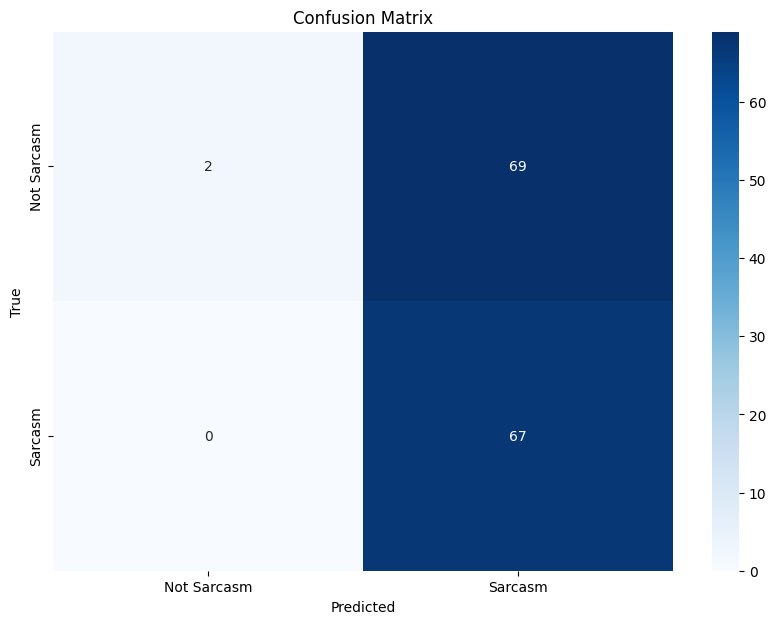

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(all_labels, all_preds, class_names=["Not Sarcasm", "Sarcasm"])